# ML741
## Assignment 1
## Classification tree
### Hannah Quass
### 24752231

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read the CSV file
df = pd.read_excel('beans.xlsx')

#### Missing values

In [3]:
# Drop observations that have missing values for the class labels
df = df.dropna(subset=['Class'])

# Impute colour with the most frequently occuring class: brown
df_cat = df.select_dtypes(exclude=[np.number])
df[df_cat.columns] = df_cat.fillna(df.mode().iloc[0])

# Impute numeric variables
df_numeric = df.select_dtypes(include=[np.number])
df[df_numeric.columns] = df_numeric.fillna(df_numeric.median())

#### Label encoding

In [3]:
# First, observe the class distributions
class_counts = df.value_counts(['Class'])
class_proportions = df.value_counts(['Class'], normalize=True)
data = {'Count': class_counts, 'Proportion': class_proportions}
class_dist = pd.DataFrame(data)
print(class_dist)

class_counts = df.value_counts(['Colour'])
class_proportions = df.value_counts(['Colour'], normalize=True)
data = {'Count': class_counts, 'Proportion': class_proportions}
class_dist = pd.DataFrame(data)
print(class_dist)

          Count  Proportion
Class                      
DERMASON   3542    0.260556
SIRA       2634    0.193762
SEKER      2025    0.148963
HOROZ      1927    0.141754
CALI       1628    0.119759
BARBUNYA   1317    0.096881
BOMBAY      521    0.038326
        Count  Proportion
Colour                   
brown    6115    0.449467
black    3541    0.260272
green    2023    0.148695
white    1926    0.141566


In [4]:
# Encode the categorical variables to be numeric

from sklearn.preprocessing import LabelEncoder
le1 = LabelEncoder()
le2 = LabelEncoder()
df['Colour'] = le1.fit_transform(df['Colour'])
df['Class'] = le2.fit_transform(df['Class'])

class_mapping1 = dict(zip(le1.classes_, le1.transform(le1.classes_)))
class_mapping2 = dict(zip(le2.classes_, le2.transform(le2.classes_)))
for original, encoded in class_mapping1.items():
    print(f"{original}: {encoded}")
for original, encoded in class_mapping2.items():
    print(f"{original}: {encoded}")

black: 0
brown: 1
green: 2
white: 3
BARBUNYA: 0
BOMBAY: 1
CALI: 2
DERMASON: 3
HOROZ: 4
SEKER: 5
SIRA: 6


### PCA to visualise the data

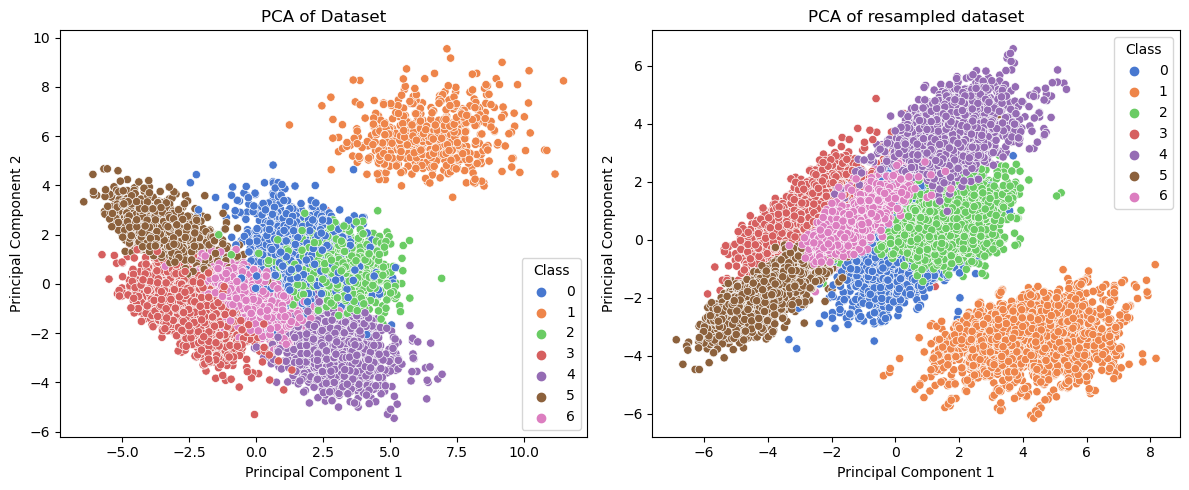

In [78]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

X = df.drop(columns=['Class'])
y = df['Class']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_resampled_scaled = scaler.fit_transform(X_resampled)

pca1 = PCA(n_components=2).fit_transform(X_scaled)
pca2 = PCA(n_components=2).fit_transform(X_resampled_scaled)

pca_df = pd.DataFrame(data=pca1, columns=['PC1', 'PC2'])
pca_df['Class'] = y.reset_index(drop=True)

pca_df_2 = pd.DataFrame(data=pca2, columns=['PC1', 'PC2'])
pca_df_2['Class'] = y_resampled.reset_index(drop=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# First plot
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=pca_df, palette='muted', ax=ax1)
ax1.set_title('PCA of Dataset')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
# Second plot
sns.scatterplot(x='PC1', y='PC2', hue='Class', data=pca_df_2, palette='muted', ax=ax2)
ax2.set_title('PCA of resampled dataset')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')

plt.tight_layout()
plt.show()

## Classification tree
This code block now contains the final model

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

X = df.drop(columns=['Class'])
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Figure out what these hyperparameters are!
clf = DecisionTreeClassifier(
    criterion="gini",
    min_samples_split=10,
    min_samples_leaf=6
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Overall accuracy: {accuracy}")
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy: {balanced_accuracy}")
print(classification_report(y_test, y_pred))
print(f'depth: {clf.get_depth()}')

Overall accuracy: 0.9786712429517038
Balanced accuracy: 0.973198342452587
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       384
           1       1.00      0.99      1.00       170
           2       0.94      0.94      0.94       511
           3       1.00      1.00      1.00      1089
           4       1.00      1.00      1.00       593
           5       1.00      1.00      1.00       571
           6       0.98      0.98      0.98       761

    accuracy                           0.98      4079
   macro avg       0.97      0.97      0.97      4079
weighted avg       0.98      0.98      0.98      4079

depth: 16


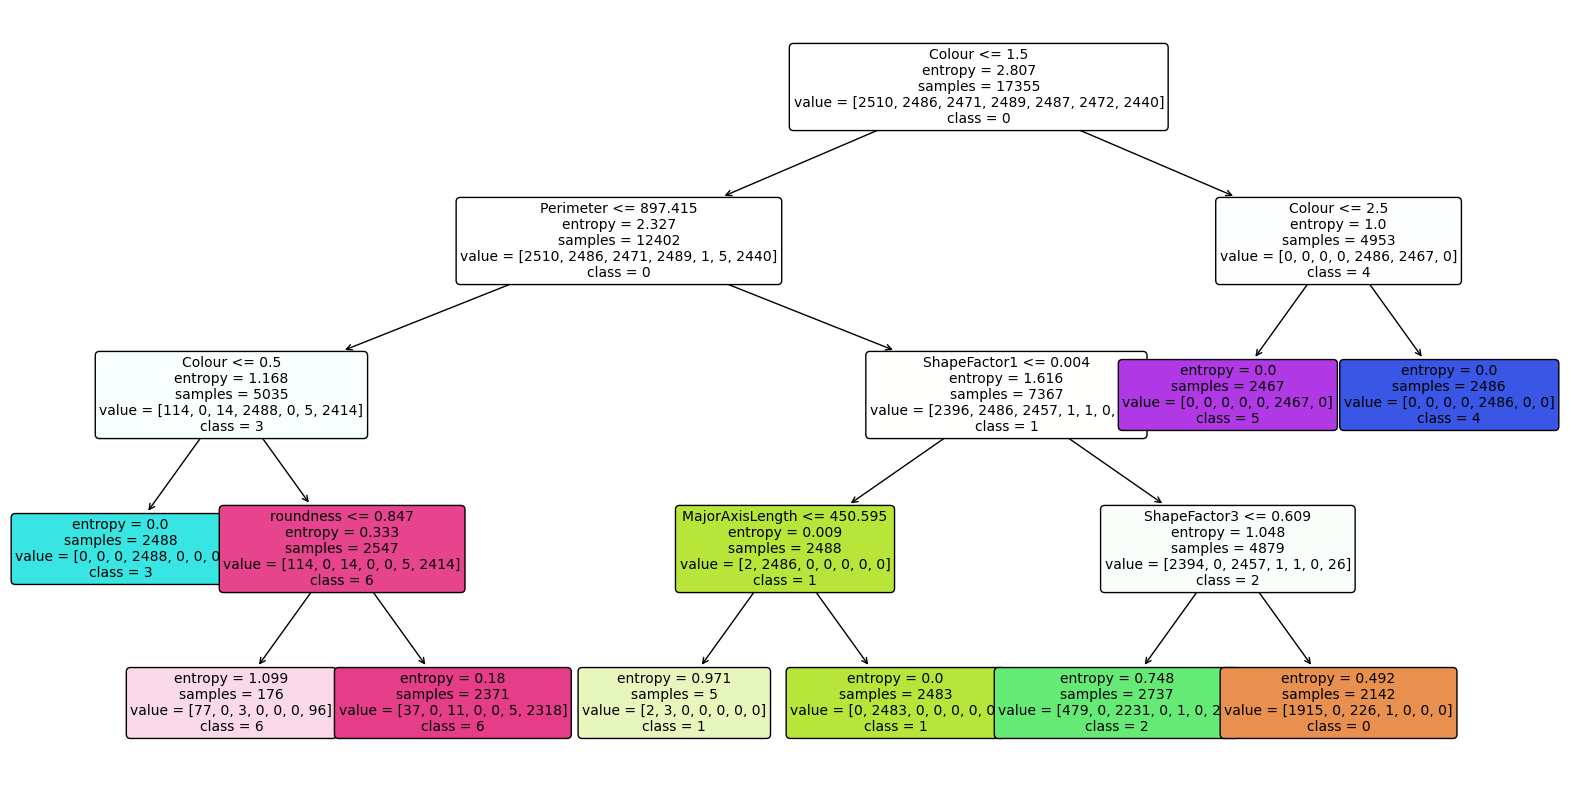

In [31]:
# For visualising the tree
from sklearn.tree import plot_tree

unique_classes = np.unique(y)
class_names = [str(cls) for cls in unique_classes]

plt.figure(figsize=(20,10))
plot_tree(clf, 
          feature_names=X.columns,  
          class_names=class_names,
          filled=True, 
          rounded=True,
          fontsize=10)
plt.show()

### Grid search with SMOTE and k-fold cross-validation

In [11]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

def custom_grid_search_with_smote(X, y, model, param_grid, cv=5, scoring='accuracy'):
    """
    Custom grid search with SMOTE applied only to training folds.
    
    Parameters:
    X : array-like of shape (n_samples, n_features)
        The input samples.
    y : array-like of shape (n_samples,)
        The target values.
    model : estimator object
        The model to be tuned.
    param_grid : dict
        Dictionary with parameters names as keys and lists of parameter settings to try as values.
    cv : int, default=5
        Number of folds for cross-validation.
    scoring : str, default='accuracy'
        Scoring metric to use. Currently only supports 'accuracy'.
    
    Returns:
    best_params : dict
        Best parameters found.
    best_score : float
        Mean cross-validated score of the best estimator.
    """
    
    best_score = -np.inf
    best_raw_score = -np.inf
    best_params = {}
    
    # Create cross-validation splits
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Iterate over all combinations of parameters
    for params in _param_grid_to_list(param_grid):
        scores = []
        raw_scores = []
        
        # Perform cross-validation
        for train_index, val_index in skf.split(X, y):
            X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]
            
            # Apply SMOTE to the training data
            smote = SMOTE(random_state=42)
            X_train_resampled, y_train_resampled = smote.fit_resample(X_train_fold, y_train_fold)
            
            # Train the model
            model.set_params(**params)
            model.fit(X_train_resampled, y_train_resampled)
            
            # Evaluate on validation set
            y_pred = model.predict(X_val_fold)
            score = balanced_accuracy_score(y_val_fold, y_pred)
            scores.append(score)
            
            raw_score = accuracy_score(y_val_fold, y_pred)
            raw_scores.append(raw_score)
        
        # Calculate mean score for this parameter combination
        mean_score = np.mean(scores)
        mean_raw_score = np.mean(raw_scores)
#         print(f'cross-valididation accuracy: {score}')
        
        # Update best parameters if we have a new best score
        if mean_score > best_score:
            best_score = mean_score
            best_params = params
        
        if mean_raw_score > best_raw_score:
            best_raw_score = mean_raw_score
    
    return best_params, best_score, best_raw_score

def _param_grid_to_list(param_grid):
    """Helper function to convert param_grid to a list of dictionaries."""
    import itertools
    
    keys = param_grid.keys()
    values = param_grid.values()
    combinations = itertools.product(*values)
    return [dict(zip(keys, combo)) for combo in combinations]

# Example usage:
from sklearn.tree import DecisionTreeClassifier

X_mine = df.drop(columns=['Class'])
y_mine = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X_mine, y_mine, test_size=0.3, random_state=42)

model = DecisionTreeClassifier()
param_grid = {
    'criterion': ['gini','entropy'],
    'min_samples_split': [2,4,6,8,10,12],
    'min_samples_leaf': [1,2,4,6,8,10],
    'ccp_alpha': [0, 0.001, 0.01, 0.02]
}

best_params, best_score, best_raw_score = custom_grid_search_with_smote(X_train, y_train, model, param_grid)
print(f"Best parameters: {best_params}")
print(f"Best cross-validation balanced accuracy: {best_score}")
print(f"Best cross-validation overall accuracy: {best_raw_score}")

Best parameters: {'criterion': 'gini', 'min_samples_split': 10, 'min_samples_leaf': 6, 'ccp_alpha': 0}
Best cross-validation balanced accuracy: 0.9757496213735577
Best cross-validation accuracy: 0.9798213347346296


### Finding the range of alpha values

Number of nodes in the last tree is: 1 with ccp_alpha: 0.14376453518766164


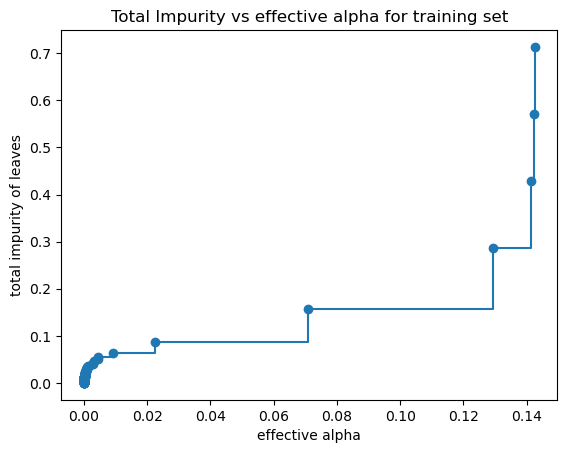

In [46]:
X = df.drop(columns=['Class'])
y = df['Class']

smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

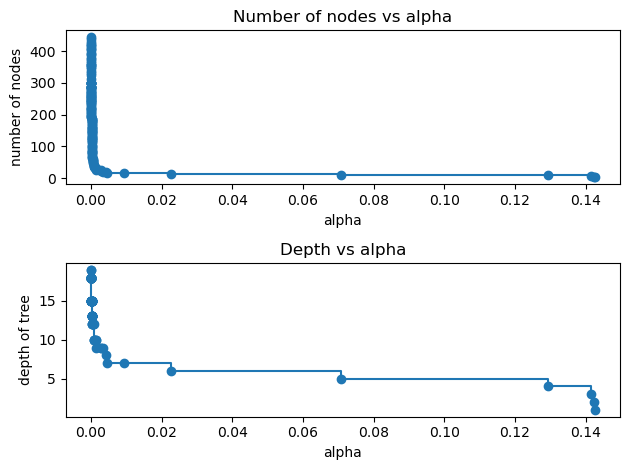

In [11]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

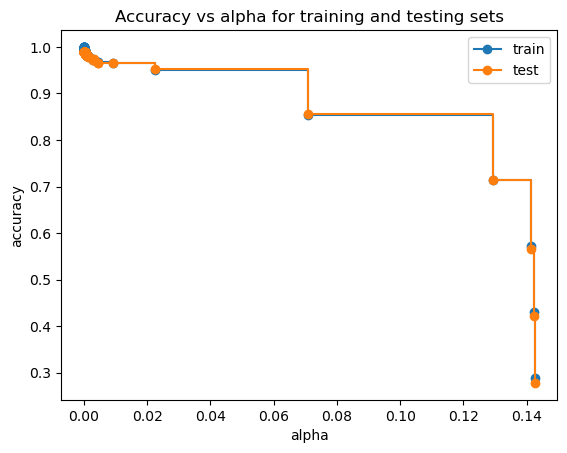

In [12]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()